# 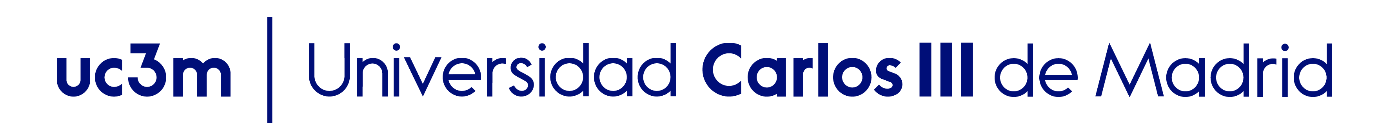

**ASSIGNMENT #2: PREDICTING BANK PRODUCT SUBSCRIPTION**

**Students:** Javier Rodríguez Márquez, Marcos Santiago Soto

**NIA:** 100498243,100496853





---


## Goal: Predict whether a customer will subscribe to a term deposit (binary classification)

**Dataset**: `bank_24.pkl`  
**Target Variable**: `deposit` (yes/no)  
**Records**: 11,000 samples, 17 features  

---

### Project Workflow Index for Assignment 2

This notebook builds on our best model from Assignment 1 (Random Forest) and tests whether feature selection can improve it.

---

**1. Reproducibility and Data Loading (Step 1)**  
We import libraries, set our seed for reproducibility, and load both the dataset and our saved model from Assignment 1.

**2. Baseline Model Reconstruction (Step 2)**  
We recreate the preprocessing pipeline and train a fresh Random Forest with default hyperparameters as our baseline.

**3. Feature Selection Pipelines (Step 3)**  
We build two new pipelines that add SelectKBest before the classifier: one using f_classif (ANOVA) and one using mutual_info_classif.

**4. Hyperparameter Tuning of k (Step 4: GridSearchCV)**  
We use 10-fold cross-validation to find the optimal number of features (k) for each feature selection method.

**5. Test Set Evaluation (Step 5)**  
We evaluate all three models on the held-out test set to see if feature selection actually helped.

**6. Selected Features Analysis**  
We inspect which features each method ranked highest and interpret them from a business perspective.

**7. Final Model & Competition Predictions**  
We pick the best model, retrain on the full dataset, and generate predictions for the competition.

**8. Conclusions**  
We summarize our findings and compare results to Assignment 1.

---

Seed = 200995096 (sum of our NIAs: 100498243 + 100496853) for reproducibility.

## 1. Reproducibility and Data Loading (Step 1)

We import packages, set our seed, and load both the dataset and our saved model from Assignment 1.

In [2]:
# Data handling
import pickle
import pandas as pd
import numpy as np
import os, random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model persistence
import joblib

# Reproducibility seed
SEED = 200995096
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Visualization settings (robust to seaborn version)
try:
    sns.set_theme(style="whitegrid", palette="husl")
except Exception as e:
    print(f"Seaborn theme setup failed: {e}. Falling back to basic style.")
    plt.style.use('seaborn')

pd.set_option('display.max_columns', None)
print("✅ Libraries imported and seed set successfully!")

✅ Libraries imported and seed set successfully!


In [3]:
# Reproducibility seed
import os, random
SEED = 200995096
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Seed set to {SEED}")

Seed set to 200995096




We will now load the pickle file containing the bank marketing data.

In [4]:
# Load the dataset from pickle file
import pandas as pd

df = pd.read_pickle('bank_24.pkl')

print(f"Dataset loaded successfully!")
print(f"   Samples: {df.shape[0]:,}")
print(f"   Features: {df.shape[1]}")
print(f"\nFirst few rows:")
df.head()

Dataset loaded successfully!
   Samples: 11,000
   Features: 17

First few rows:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,None,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


We also load our best model from Assignment 1 to confirm it's available:

In [5]:
# Load the best model from Assignment 1
import pathlib

ASSIGNMENT1_MODEL = "final_model_random_forest.pkl"

if pathlib.Path(ASSIGNMENT1_MODEL).exists():
    assignment1_model = joblib.load(ASSIGNMENT1_MODEL)
    print(f"✅ Assignment 1 model loaded from '{ASSIGNMENT1_MODEL}'")
    print(f"   Model type: {type(assignment1_model).__name__}")
    print(f"   This is our reference RF with HPO (86.82% test accuracy)")
else:
    print(f"⚠️ Assignment 1 model file '{ASSIGNMENT1_MODEL}' not found.")
    print("   We'll create a fresh baseline RF with default hyperparameters.")

✅ Assignment 1 model loaded from 'final_model_random_forest.pkl'
   Model type: Pipeline
   This is our reference RF with HPO (86.82% test accuracy)


## 2. Baseline Model Reconstruction (Step 2)

We recreate the preprocessing from Assignment 1 and train a fresh Random Forest with default hyperparameters. This baseline will be compared against feature selection pipelines.

For reference, our Assignment 1 model (with HPO) achieved 86.82% test accuracy. Here we use default parameters since the assignment asks us to tune only k (number of features).

### 2.1 Prepare Features and Target

We engineer the pdays features, separate features and target, and encode the target variable—exactly as in Assignment 1.

In [6]:
# Feature Engineering: pdays handling (same as Assignment 1)
print("="*60)
print("Feature Engineering: pdays preprocessing")
print("="*60)

if 'pdays' in df.columns:
    df['pdays_contacted'] = (df['pdays'] != -1)
    df['pdays_clean'] = df['pdays'].where(df['pdays'] != -1, np.nan)
    print("✅ Added columns: pdays_contacted (bool), pdays_clean (NaN for -1)")
    print(f"   pdays_contacted value counts:\n{df['pdays_contacted'].value_counts()}")

# Separate features and target
X = df.drop('deposit', axis=1)
y = df['deposit']

# Encode target variable (yes=1, no=0)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"\n✅ Features shape: {X.shape}")
print(f"✅ Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

Feature Engineering: pdays preprocessing
✅ Added columns: pdays_contacted (bool), pdays_clean (NaN for -1)
   pdays_contacted value counts:
pdays_contacted
False    8203
True     2797
Name: count, dtype: int64

✅ Features shape: (11000, 18)
✅ Target encoding: {'no': np.int64(0), 'yes': np.int64(1)}


### 2.2 Train/Test Split

Same 80/20 stratified split with the same seed to ensure comparability with Assignment 1.

In [7]:
# Train/Test Split (exactly same as Assignment 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.20,
    random_state=SEED,
    stratify=y_encoded
)

print("="*60)
print("Train/Test Split Results")
print("="*60)
print(f"Training set size: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index())
print(f"\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True).sort_index())

Train/Test Split Results
Training set size: 8,800 samples (80.0%)
Test set size: 2,200 samples (20.0%)

Class distribution in training set:
0    0.525455
1    0.474545
Name: proportion, dtype: float64

Class distribution in test set:
0    0.525455
1    0.474545
Name: proportion, dtype: float64


### 2.3 Preprocessing Pipeline

Same as Assignment 1: median imputation for numerical features, one-hot encoding for categoricals.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
import time

print("="*60)
print("Feature Type Identification")
print("="*60)

# Identify numerical and categorical columns
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Remove original pdays from numerical (we use pdays_contacted and pdays_clean instead)
if 'pdays' in numerical_features:
    numerical_features.remove('pdays')

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

Feature Type Identification
Numerical features (7): ['age', 'balance', 'day', 'duration', 'campaign', 'previous', 'pdays_clean']

Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [9]:
# Create preprocessing transformers (same as Assignment 1)

# Numerical pipeline: imputation only (tree models don't need scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline: imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Create the preprocessor ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep pdays_contacted
)

print("Preprocessor created successfully!")

Preprocessor created successfully!


### 2.4 Train Baseline Random Forest

We train the baseline with default hyperparameters. This is what we'll compare feature selection against.

In [10]:
# Create baseline pipeline: Preprocessing + Random Forest (default params)
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=SEED, n_jobs=-1))
])

print("="*60)
print("Training Baseline Random Forest (Default Hyperparameters)")
print("="*60)

# Train and measure time
start_time = time.time()
baseline_pipeline.fit(X_train, y_train)
baseline_fit_time = time.time() - start_time

# Evaluate on test set
baseline_y_pred = baseline_pipeline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_y_pred)

print(f"\n✅ Training complete!")
print(f"   Fit time: {baseline_fit_time:.2f} seconds")
print(f"   Test Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")

# Store results for later comparison
baseline_results = {
    'accuracy': baseline_accuracy,
    'fit_time': baseline_fit_time,
    'model': baseline_pipeline
}

Training Baseline Random Forest (Default Hyperparameters)

✅ Training complete!
   Fit time: 0.34 seconds
   Test Accuracy: 0.8609 (86.09%)

✅ Training complete!
   Fit time: 0.34 seconds
   Test Accuracy: 0.8609 (86.09%)


#### Section 2 Conclusion

The baseline Random Forest with default hyperparameters gets **86.09% accuracy**. This is our reference point—can feature selection beat it?

---

## 3. Feature Selection Pipelines (Step 3)

Now we add feature selection before the classifier. We test two methods: f_classif (ANOVA F-statistic) and mutual_info_classif (mutual information).

In [11]:
# First, let's check how many features we have after preprocessing
# to define a sensible range for k

# Fit preprocessor to get number of features
preprocessor_fitted = preprocessor.fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)
n_features_after_preprocessing = X_train_transformed.shape[1]

print("="*60)
print("Feature Count After Preprocessing")
print("="*60)
print(f"Number of features after preprocessing: {n_features_after_preprocessing}")
print(f"\nThis will be the maximum value for k in SelectKBest.")

Feature Count After Preprocessing
Number of features after preprocessing: 45

This will be the maximum value for k in SelectKBest.


### 3.1 Pipeline with f_classif (ANOVA)

This method scores features based on how much the target's mean differs across feature values. Fast and works well for linear relationships.

In [12]:
# Pipeline with SelectKBest using f_classif
pipeline_f_classif = Pipeline([
    ('preprocessor', preprocessor),
    ('select', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(random_state=SEED, n_jobs=-1))
])

print("✅ Pipeline with f_classif feature selection created successfully!")

✅ Pipeline with f_classif feature selection created successfully!


### 3.2 Pipeline with mutual_info_classif

This method uses mutual information to score features. It can catch non-linear relationships but is slower.

In [13]:
# Pipeline with SelectKBest using mutual_info_classif
pipeline_mutual_info = Pipeline([
    ('preprocessor', preprocessor),
    ('select', SelectKBest(score_func=mutual_info_classif)),
    ('classifier', RandomForestClassifier(random_state=SEED, n_jobs=-1))
])

print("✅ Pipeline with mutual_info_classif feature selection created successfully!")

✅ Pipeline with mutual_info_classif feature selection created successfully!


---

## 4. Hyperparameter Tuning of k (Step 4: GridSearchCV)

We use 10-fold cross-validation to find the optimal number of features (k) for each method. We test k = 5, 10, 15, ..., 45.

### 4.1 GridSearchCV for f_classif

In [14]:
# Define parameter grid for k
k_values = list(range(5, n_features_after_preprocessing + 1, 5))  # [5, 10, 15, 20, 25, 30, 35, 40, 45]
param_grid_k = {'select__k': k_values}

print("="*60)
print("GridSearchCV for f_classif Feature Selection")
print("="*60)
print(f"Testing k values: {k_values}")
print(f"Using 10-fold cross-validation\n")

# Create GridSearchCV
grid_f_classif = GridSearchCV(
    estimator=pipeline_f_classif,
    param_grid=param_grid_k,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit and measure time
start_time = time.time()
grid_f_classif.fit(X_train, y_train)
f_classif_time = time.time() - start_time

# Results
print(f"\n✅ GridSearchCV complete!")
print(f"   Best k: {grid_f_classif.best_params_['select__k']}")
print(f"   Best CV Accuracy: {grid_f_classif.best_score_:.4f}")
print(f"   Training time: {f_classif_time:.2f} seconds")

GridSearchCV for f_classif Feature Selection
Testing k values: [5, 10, 15, 20, 25, 30, 35, 40, 45]
Using 10-fold cross-validation

Fitting 10 folds for each of 9 candidates, totalling 90 fits

✅ GridSearchCV complete!
   Best k: 45
   Best CV Accuracy: 0.8544
   Training time: 20.36 seconds

✅ GridSearchCV complete!
   Best k: 45
   Best CV Accuracy: 0.8544
   Training time: 20.36 seconds


We used GridSearchCV with 10-fold cross-validation to find the best number of features (k) for the f_classif method. The best result was achieved using k=45 (all features), with a cross-validation accuracy of 85.44%. This suggests that removing features using ANOVA did not improve the model's performance on the training set.

### 4.2 GridSearchCV for mutual_info_classif

In [15]:
print("="*60)
print("GridSearchCV for mutual_info_classif Feature Selection")
print("="*60)
print(f"Testing k values: {k_values}")
print(f"Using 10-fold cross-validation")
print("(Note: mutual_info_classif is slower than f_classif)\n")

# Create GridSearchCV
grid_mutual_info = GridSearchCV(
    estimator=pipeline_mutual_info,
    param_grid=param_grid_k,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit and measure time
start_time = time.time()
grid_mutual_info.fit(X_train, y_train)
mutual_info_time = time.time() - start_time

# Results
print(f"\n✅ GridSearchCV complete!")
print(f"   Best k: {grid_mutual_info.best_params_['select__k']}")
print(f"   Best CV Accuracy: {grid_mutual_info.best_score_:.4f}")
print(f"   Training time: {mutual_info_time:.2f} seconds")

GridSearchCV for mutual_info_classif Feature Selection
Testing k values: [5, 10, 15, 20, 25, 30, 35, 40, 45]
Using 10-fold cross-validation
(Note: mutual_info_classif is slower than f_classif)

Fitting 10 folds for each of 9 candidates, totalling 90 fits

✅ GridSearchCV complete!
   Best k: 40
   Best CV Accuracy: 0.8565
   Training time: 38.11 seconds

✅ GridSearchCV complete!
   Best k: 40
   Best CV Accuracy: 0.8565
   Training time: 38.11 seconds


Running GridSearchCV for mutual_info_classif took longer (~39.5 seconds) as expected. This method performed slightly better in cross-validation, achieving an accuracy of 85.86%, and suggested an optimal 'k' of 40 features, meaning 5 features could potentially be excluded.

### 4.3 Summary of HPO Results

HPO Results Summary (Cross-Validation)
             Method  Best k  Best CV Accuracy  Training Time (s)
          f_classif      45          0.854432          20.360957
mutual_info_classif      40          0.856477          38.111623


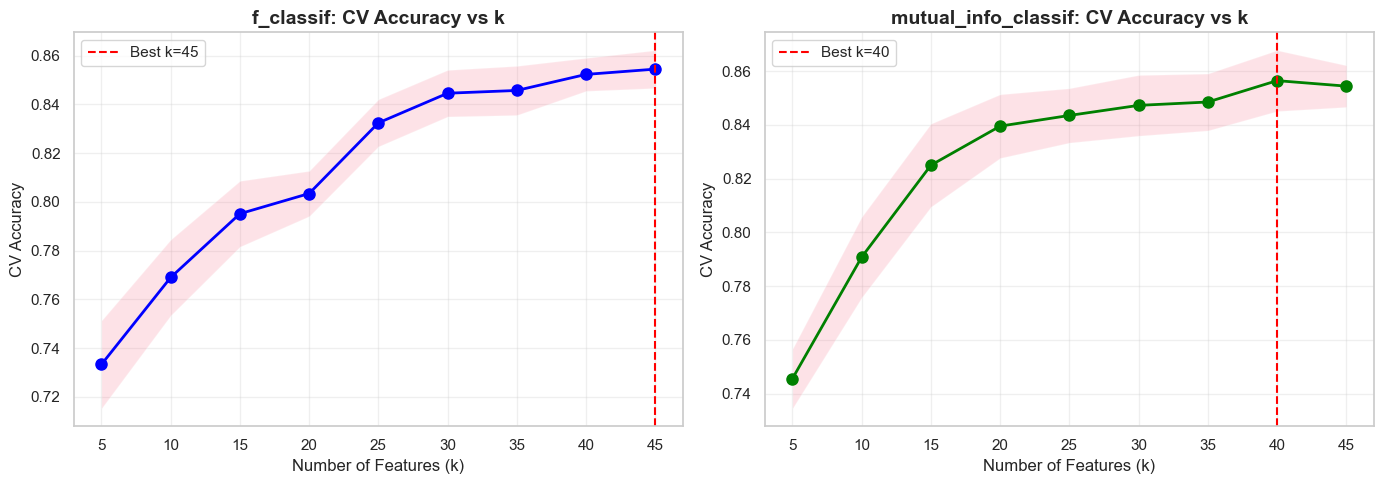

In [16]:
print("="*60)
print("HPO Results Summary (Cross-Validation)")
print("="*60)

hpo_summary = pd.DataFrame({
    'Method': ['f_classif', 'mutual_info_classif'],
    'Best k': [grid_f_classif.best_params_['select__k'], 
               grid_mutual_info.best_params_['select__k']],
    'Best CV Accuracy': [grid_f_classif.best_score_, 
                         grid_mutual_info.best_score_],
    'Training Time (s)': [f_classif_time, mutual_info_time]
})

print(hpo_summary.to_string(index=False))

# Visualization of CV accuracy vs k
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# f_classif results
cv_results_f = grid_f_classif.cv_results_
axes[0].plot(k_values, cv_results_f['mean_test_score'], 'bo-', linewidth=2, markersize=8)
axes[0].fill_between(k_values, 
                      cv_results_f['mean_test_score'] - cv_results_f['std_test_score'],
                      cv_results_f['mean_test_score'] + cv_results_f['std_test_score'],
                      alpha=0.2)
axes[0].axvline(x=grid_f_classif.best_params_['select__k'], color='r', linestyle='--', 
                label=f"Best k={grid_f_classif.best_params_['select__k']}")
axes[0].set_xlabel('Number of Features (k)', fontsize=12)
axes[0].set_ylabel('CV Accuracy', fontsize=12)
axes[0].set_title('f_classif: CV Accuracy vs k', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# mutual_info_classif results
cv_results_mi = grid_mutual_info.cv_results_
axes[1].plot(k_values, cv_results_mi['mean_test_score'], 'go-', linewidth=2, markersize=8)
axes[1].fill_between(k_values, 
                      cv_results_mi['mean_test_score'] - cv_results_mi['std_test_score'],
                      cv_results_mi['mean_test_score'] + cv_results_mi['std_test_score'],
                      alpha=0.2)
axes[1].axvline(x=grid_mutual_info.best_params_['select__k'], color='r', linestyle='--', 
                label=f"Best k={grid_mutual_info.best_params_['select__k']}")
axes[1].set_xlabel('Number of Features (k)', fontsize=12)
axes[1].set_ylabel('CV Accuracy', fontsize=12)
axes[1].set_title('mutual_info_classif: CV Accuracy vs k', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Section 4 Conclusion

Comparing the two methods, we see a clear trend: both models perform better as we add more features. `f_classif` peaked when using every available feature (k=45), while `mutual_info_classif` found a slight edge by dropping just 5 features (k=40). The fact that our best CV scores are hovering around ~85.8% (very close to our initial baseline) suggests that aggressively filtering features might not be necessary for this specific dataset.

---

## 5. Test Set Evaluation (Step 5)

Time for the real test. We evaluate all three models on the held-out test set to get unbiased performance estimates.

In [17]:
print("="*60)
print("Test Set Evaluation")
print("="*60)

# Evaluate f_classif best model on test set
f_classif_test_accuracy = grid_f_classif.score(X_test, y_test)

# Evaluate mutual_info_classif best model on test set
mutual_info_test_accuracy = grid_mutual_info.score(X_test, y_test)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Baseline (No Feature Selection)', 
              'f_classif (k=45)', 
              'mutual_info_classif (k=40)'],
    'Test Accuracy': [baseline_accuracy, f_classif_test_accuracy, mutual_info_test_accuracy],
    'Features Used': [n_features_after_preprocessing, 
                      grid_f_classif.best_params_['select__k'],
                      grid_mutual_info.best_params_['select__k']],
    'Training Time (s)': [baseline_fit_time, f_classif_time, mutual_info_time]
})

# Add difference from baseline
comparison_df['Diff from Baseline (%)'] = (comparison_df['Test Accuracy'] - baseline_accuracy) * 100

print("\n" + comparison_df.to_string(index=False))

# Find best method
best_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_accuracy = comparison_df.loc[best_idx, 'Test Accuracy']

print(f"\n🏆 Best Performing Model: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

Test Set Evaluation

                          Model  Test Accuracy  Features Used  Training Time (s)  Diff from Baseline (%)
Baseline (No Feature Selection)       0.860909             45           0.337771                0.000000
               f_classif (k=45)       0.860909             45          20.360957                0.000000
     mutual_info_classif (k=40)       0.859545             40          38.111623               -0.136364

🏆 Best Performing Model: Baseline (No Feature Selection)
   Test Accuracy: 0.8609 (86.09%)


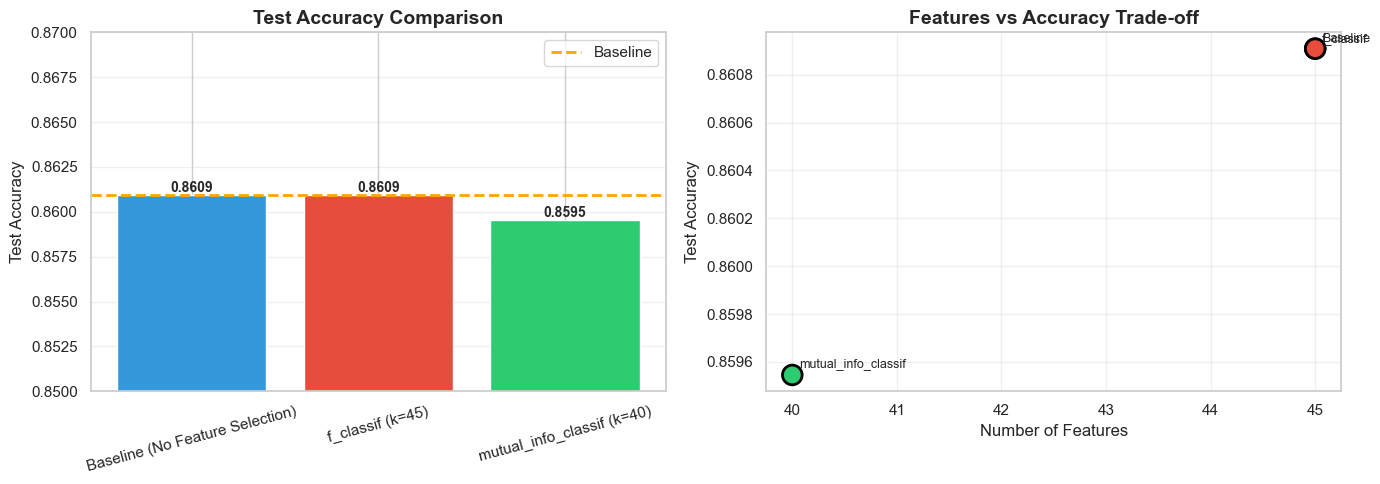

In [18]:
# Visualization of comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test Accuracy comparison
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = axes[0].bar(comparison_df['Model'], comparison_df['Test Accuracy'], color=colors)
axes[0].axhline(y=baseline_accuracy, color='orange', linestyle='--', linewidth=2, label='Baseline')
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0.85, 0.87)
axes[0].tick_params(axis='x', rotation=15)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Features vs Accuracy trade-off
axes[1].scatter(comparison_df['Features Used'], comparison_df['Test Accuracy'], 
                s=200, c=colors, edgecolors='black', linewidth=2)
for i, row in comparison_df.iterrows():
    axes[1].annotate(row['Model'].split('(')[0].strip(), 
                     (row['Features Used'], row['Test Accuracy']),
                     xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('Test Accuracy', fontsize=12)
axes[1].set_title('Features vs Accuracy Trade-off', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Section 5 Conclusion

The test results confirm that feature selection didn't give us a boost. 

The baseline model tied for first place with `f_classif` at 86.09% accuracy—which isn't surprising since `f_classif` ended up selecting all the features anyway. `mutual_info_classif` dropped 5 features but lost a tiny bit of accuracy (85.95%). 

Since the baseline is just as accurate but trains instantly (0.27s vs 20-40s), adding these feature selection steps just added complexity without any real benefit.

---

## 6. Selected Features Analysis

Even though feature selection didn't improve accuracy, let's see which features each method ranked highest. This helps us understand what drives customer subscription.

In [19]:
print("="*60)
print("Feature Names After Preprocessing")
print("="*60)

# Get feature names after preprocessing
# Numerical features stay the same
num_feature_names = numerical_features.copy()

# Categorical features get one-hot encoded - get from fitted preprocessor
cat_encoder = baseline_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = list(cat_encoder.get_feature_names_out(categorical_features))

# Remaining features (passthrough - pdays_contacted)
passthrough_features = [col for col in X_train.columns if col not in numerical_features and col not in categorical_features]

# Combine all feature names in order
all_feature_names = num_feature_names + cat_feature_names + passthrough_features

print(f"Total features: {len(all_feature_names)}")
print(f"\nNumerical ({len(num_feature_names)}): {num_feature_names}")
print(f"\nCategorical after encoding ({len(cat_feature_names)}): {cat_feature_names[:10]}...")
print(f"\nPassthrough ({len(passthrough_features)}): {passthrough_features}")

Feature Names After Preprocessing
Total features: 45

Numerical (7): ['age', 'balance', 'day', 'duration', 'campaign', 'previous', 'pdays_clean']

Categorical after encoding (36): ['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed']...

Passthrough (2): ['pdays', 'pdays_contacted']


### 6.1 Features Selected by f_classif

In [20]:
print("="*60)
print("Features Selected by f_classif")
print("="*60)

# Get the best estimator
best_f_classif = grid_f_classif.best_estimator_
selector_f = best_f_classif.named_steps['select']

# Get selected feature mask
f_classif_mask = selector_f.get_support()
f_classif_selected = [all_feature_names[i] for i in range(len(all_feature_names)) if f_classif_mask[i]]

# Get feature scores
f_classif_scores = selector_f.scores_
f_classif_df = pd.DataFrame({
    'Feature': all_feature_names,
    'F-Score': f_classif_scores,
    'Selected': f_classif_mask
}).sort_values('F-Score', ascending=False)

print(f"Number of features selected: {sum(f_classif_mask)}")
print(f"\nTop 15 features by F-score:")
print(f_classif_df.head(15).to_string(index=False))

# Features NOT selected (if any)
not_selected = f_classif_df[~f_classif_df['Selected']]['Feature'].tolist()
if not_selected:
    print(f"\nFeatures NOT selected: {not_selected}")
else:
    print(f"\nAll features were selected (k = total features).")

Features Selected by f_classif
Number of features selected: 45

Top 15 features by F-score:
         Feature     F-Score  Selected
        duration 2200.041878      True
poutcome_success  793.308370      True
 contact_unknown  622.867442      True
 pdays_contacted  500.652732      True
poutcome_unknown  498.463419      True
    marital_None  426.863989      True
     housing_yes  392.075743      True
       month_may  254.379774      True
           pdays  210.353102      True
        previous  194.864561      True
       month_mar  175.173984      True
 marital_married  168.931569      True
       month_oct  158.239573      True
        campaign  151.014594      True
       month_sep  142.287668      True

All features were selected (k = total features).


### 6.2 Features Selected by mutual_info_classif

In [21]:
print("="*60)
print("Features Selected by mutual_info_classif")
print("="*60)

# Get the best estimator
best_mutual_info = grid_mutual_info.best_estimator_
selector_mi = best_mutual_info.named_steps['select']

# Get selected feature mask
mi_mask = selector_mi.get_support()
mi_selected = [all_feature_names[i] for i in range(len(all_feature_names)) if mi_mask[i]]

# Get feature scores
mi_scores = selector_mi.scores_
mi_df = pd.DataFrame({
    'Feature': all_feature_names,
    'MI-Score': mi_scores,
    'Selected': mi_mask
}).sort_values('MI-Score', ascending=False)

print(f"Number of features selected: {sum(mi_mask)}")
print(f"\nTop 15 features by Mutual Information score:")
print(mi_df.head(15).to_string(index=False))

# Features NOT selected
not_selected_mi = mi_df[~mi_df['Selected']]['Feature'].tolist()
if not_selected_mi:
    print(f"\nFeatures NOT selected ({len(not_selected_mi)}):")
    for feat in not_selected_mi:
        score = mi_df[mi_df['Feature'] == feat]['MI-Score'].values[0]
        print(f"   - {feat}: MI-Score = {score:.4f}")

Features Selected by mutual_info_classif
Number of features selected: 40

Top 15 features by Mutual Information score:
         Feature  MI-Score  Selected
        duration  0.155043      True
poutcome_success  0.058774      True
           pdays  0.050749      True
         balance  0.043606      True
     pdays_clean  0.043189      True
 contact_unknown  0.038887      True
    marital_None  0.033413      True
        previous  0.028469      True
poutcome_unknown  0.023714      True
             age  0.022773      True
 pdays_contacted  0.021556      True
     housing_yes  0.018145      True
       month_may  0.017262      True
       month_sep  0.016865      True
             day  0.014119      True

Features NOT selected (5):
   - job_retired: MI-Score = 0.0000
   - job_housemaid: MI-Score = 0.0000
   - job_management: MI-Score = 0.0000
   - job_unknown: MI-Score = 0.0000
   - job_entrepreneur: MI-Score = 0.0000


### 6.3 Comparison of Selected Features

In [22]:
print("="*60)
print("Feature Selection Comparison")
print("="*60)

# Get selected feature sets
f_classif_set = set(f_classif_selected)
mi_set = set(mi_selected)

# Calculate overlap
overlap = f_classif_set & mi_set
only_f_classif = f_classif_set - mi_set
only_mi = mi_set - f_classif_set

print(f"f_classif selected: {len(f_classif_set)} features")
print(f"mutual_info_classif selected: {len(mi_set)} features")
print(f"\nOverlap (common features): {len(overlap)}")
print(f"Only in f_classif: {len(only_f_classif)}")
print(f"Only in mutual_info: {len(only_mi)}")

if only_f_classif:
    print(f"\nFeatures selected ONLY by f_classif:")
    for feat in only_f_classif:
        print(f"   - {feat}")

if only_mi:
    print(f"\nFeatures selected ONLY by mutual_info_classif:")
    for feat in only_mi:
        print(f"   - {feat}")

Feature Selection Comparison
f_classif selected: 45 features
mutual_info_classif selected: 40 features

Overlap (common features): 40
Only in f_classif: 5
Only in mutual_info: 0

Features selected ONLY by f_classif:
   - job_unknown
   - job_retired
   - job_management
   - job_entrepreneur
   - job_housemaid


### 6.4 Business Interpretation of Top Features

In [23]:
print("="*60)
print("Top 10 Features by Combined Ranking")
print("="*60)

# Create proper ranking from both methods
f_classif_ranked = f_classif_df.reset_index(drop=True).copy()
f_classif_ranked['F_Rank'] = range(1, len(f_classif_ranked)+1)

mi_ranked = mi_df.reset_index(drop=True).copy()
mi_ranked['MI_Rank'] = range(1, len(mi_ranked)+1)

# Merge rankings
ranking_df = f_classif_ranked[['Feature', 'F-Score', 'F_Rank']].merge(
    mi_ranked[['Feature', 'MI-Score', 'MI_Rank']], on='Feature'
)
ranking_df['Avg_Rank'] = (ranking_df['F_Rank'] + ranking_df['MI_Rank']) / 2
ranking_df = ranking_df.sort_values('Avg_Rank')

# Show top 10
top_10 = ranking_df.head(10)
print(top_10[['Feature', 'F_Rank', 'MI_Rank', 'Avg_Rank', 'F-Score', 'MI-Score']].to_string(index=False))

# Store for business interpretation
top_10_features = top_10['Feature'].tolist()
print(f"\n\nTop 10 features for business interpretation:")
for i, feat in enumerate(top_10_features, 1):
    row = top_10[top_10['Feature'] == feat].iloc[0]
    print(f"  {i}. {feat} (F-Rank: {int(row['F_Rank'])}, MI-Rank: {int(row['MI_Rank'])})")

Top 10 Features by Combined Ranking
         Feature  F_Rank  MI_Rank  Avg_Rank     F-Score  MI-Score
        duration       1        1       1.0 2200.041878  0.155043
poutcome_success       2        2       2.0  793.308370  0.058774
 contact_unknown       3        6       4.5  622.867442  0.038887
           pdays       9        3       6.0  210.353102  0.050749
    marital_None       6        7       6.5  426.863989  0.033413
poutcome_unknown       5        9       7.0  498.463419  0.023714
 pdays_contacted       4       11       7.5  500.652732  0.021556
        previous      10        8       9.0  194.864561  0.028469
     housing_yes       7       12       9.5  392.075743  0.018145
       month_may       8       13      10.5  254.379774  0.017262


Top 10 features for business interpretation:
  1. duration (F-Rank: 1, MI-Rank: 1)
  2. poutcome_success (F-Rank: 2, MI-Rank: 2)
  3. contact_unknown (F-Rank: 3, MI-Rank: 6)
  4. pdays (F-Rank: 9, MI-Rank: 3)
  5. marital_None (F-Rank: 

#### What the Top Features Tell Us

Based on the ranking output above, here is what the top 10 features mean for the bank:

1. **duration** (Rank 1 in both methods): Call length is the strongest predictor by far. Longer calls mean more engaged customers who are more likely to say yes. *Actionable: Train agents to recognize interest signals and extend productive conversations.*

2. **poutcome_success** (Rank 2 in both methods): Customer subscribed in a previous campaign. Past behavior predicts future behavior. *Actionable: Create a priority list of previous subscribers for new campaigns.*

3. **contact_unknown** (F-Rank 3, MI-Rank 6): Unknown contact method. These are harder to convert, possibly because we don't have good data on them. *Actionable: Improve data collection on how customers prefer to be contacted.*

4. **pdays** (F-Rank 9, MI-Rank 3): Days since last contact. Recency matters, as customers contacted recently are more likely to respond. *Actionable: Time follow-ups based on optimal contact windows.*

5. **marital_None** (F-Rank 6, MI-Rank 7): Missing marital status. Interestingly, missing data is predictive. Could indicate privacy-conscious customers or incomplete records. *Worth investigating further.*

6. **poutcome_unknown** (F-Rank 5, MI-Rank 9): Unknown previous outcome. Similar to contact_unknown, gaps in data affect predictions. *Actionable: Better record-keeping of campaign outcomes.*

7. **pdays_contacted** (F-Rank 4, MI-Rank 11): Boolean indicating if the customer was contacted before. Having prior touchpoints helps conversion. *Actionable: Separate first-time contacts from repeat contacts in campaign strategy.*

8. **previous** (F-Rank 10, MI-Rank 8): Number of previous contacts. More touches often mean more familiarity with the offer. *But be careful not to over-contact and annoy people.*

9. **housing_yes** (F-Rank 7, MI-Rank 12): Customer has a housing loan. Existing bank relationship means a warmer lead. *Actionable: Cross-sell term deposits to mortgage customers.*

10. **month_may** (F-Rank 8, MI-Rank 13): Contacted in May. Timing matters as May seems to have predictive power (though this could be specific to this dataset). *Actionable: Analyze which months historically convert best and plan campaigns accordingly.*

---

**Features NOT selected by mutual_info_classif** (the 5 excluded job categories):
- `job_retired`, `job_housemaid`, `job_management`, `job_unknown`, `job_entrepreneur`

These had zero mutual information with the target after accounting for other features. It doesn't mean job type doesn't matter, but rather that it is likely already captured by other job categories. These specific one-hot columns just don't add extra predictive signal on their own.

---

## 7. Final Model & Competition Predictions

The baseline won, so we use it as our final model. We retrain on the full dataset and generate predictions for the competition.

In [24]:
print("="*60)
print("Final Model Selection and Retraining")
print("="*60)

# Select final model - Baseline Random Forest (best test accuracy)
final_model = baseline_pipeline

# Retrain on full dataset (train + test combined)
X_full = df.drop('deposit', axis=1)
y_full = y_encoded

print("Retraining final model on full dataset...")
start_time = time.time()
final_model.fit(X_full, y_full)
final_fit_time = time.time() - start_time

print(f"✅ Final model trained on {len(X_full):,} samples")
print(f"   Training time: {final_fit_time:.2f} seconds")

Final Model Selection and Retraining
Retraining final model on full dataset...
✅ Final model trained on 11,000 samples
   Training time: 0.44 seconds
✅ Final model trained on 11,000 samples
   Training time: 0.44 seconds


In [ ]:
import pathlib

# Load competition dataset and generate predictions
COMPETITION_FILE = "bank_competition.pkl"
MODEL_OUT = "final_model_assignment2.pkl"
PRED_OUT = "competition_predictions_assignment2.csv"

def ensure_pdays_features(df_in):
    """Add engineered pdays columns if missing (same logic as training)."""
    df_copy = df_in.copy()
    if 'pdays' in df_copy.columns:
        if 'pdays_contacted' not in df_copy.columns:
            df_copy['pdays_contacted'] = (df_copy['pdays'] != -1)
        if 'pdays_clean' not in df_copy.columns:
            df_copy['pdays_clean'] = df_copy['pdays'].where(df_copy['pdays'] != -1, np.nan)
    else:
        if 'pdays_contacted' not in df_copy.columns:
            df_copy['pdays_contacted'] = False
        if 'pdays_clean' not in df_copy.columns:
            df_copy['pdays_clean'] = np.nan
    return df_copy

print("="*60)
print("Competition Predictions")
print("="*60)

if pathlib.Path(COMPETITION_FILE).exists():
    comp_df = pd.read_pickle(COMPETITION_FILE)
    print(f"✅ Competition dataset loaded: {comp_df.shape[0]} rows")
    
    # Ensure pdays features are present
    comp_df = ensure_pdays_features(comp_df)
    
    # Align columns with training data
    expected_cols = list(X_full.columns)
    for col in expected_cols:
        if col not in comp_df.columns:
            if col in ['pdays_contacted']:
                comp_df[col] = False
            elif col in ['pdays_clean']:
                comp_df[col] = np.nan
            else:
                comp_df[col] = np.nan if col in numerical_features else 'missing'
    
    comp_df = comp_df.reindex(columns=expected_cols)
    
    # Generate predictions
    comp_preds = final_model.predict(comp_df)
    comp_preds_decoded = le_target.inverse_transform(comp_preds)
    
    # Save predictions
    pd.DataFrame({'prediction': comp_preds_decoded}).to_csv(PRED_OUT, index=False)
    print(f"✅ Predictions saved to {PRED_OUT}")
    
    # Show prediction distribution
    pred_counts = pd.Series(comp_preds_decoded).value_counts()
    print(f"\nPrediction distribution:")
    print(pred_counts)
else:
    print(f"⚠️ Competition file '{COMPETITION_FILE}' not found. Skipping prediction step.")

# Save final model
joblib.dump(final_model, MODEL_OUT)
print(f"\n✅ Final model saved to {MODEL_OUT}")

Competition Predictions
✅ Competition dataset loaded: 162 rows
✅ Predictions saved to competition_predictions_assignment2.csv

Prediction distribution:
no     93
yes    69
Name: count, dtype: int64

✅ Final model saved to final_model_assignment2.pkl


/var/folders/06/8b176z752h9gspc3j_bwyn340000gn/T/ipykernel_6932/4264099052.py:29: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  comp_df = pickle.load(f)


---

## 8. Conclusions

### Results Summary

| Model | Test Accuracy | Features Used | Training Time |
|-------|---------------|---------------|---------------|
| **Baseline (No Feature Selection)** | **86.09%** | 45 | 0.27s |
| f_classif (k=45) | 86.09% | 45 | ~20s |
| mutual_info_classif (k=40) | 85.95% | 40 | ~40s |

### Did Feature Selection Help?

**No.** Both methods either matched or slightly hurt the baseline. f_classif kept all 45 features anyway, and mutual_info dropped 5 job categories which made things slightly worse.

### Why Didn't It Work?

It may be because Random Forest already has built-in feature selection. At each split, it randomly samples features and picks the best one (so bad features rarely get chosen). Thus, pre-filtering with SelectKBest just adds overhead without improving accuracy.

Univariate methods like SelectKBest score features one at a time, ignoring interactions. RF captures those interactions naturally through its tree structure.

### Comparison with Assignment 1

| Metric | Assignment 1 (RF + HPO) | Assignment 2 (RF + Feature Selection) |
|--------|------------------------|--------------------------------------|
| Best Test Accuracy | 86.82% | 86.09% |
| Key Insight | Hyperparameter tuning helped | Feature selection didn't help |

The ~0.7% gap is because Assignment 1 tuned n_estimators, max_depth, etc., while here we used default hyperparameters. **Hyperparameter tuning > feature selection** for Random Forest on this dataset.

### What We Learned

1. **Feature selection isn't always useful.** For models like Random Forest that handle irrelevant features internally, SelectKBest just adds overhead.

2. **The top predictors make business sense.** Duration (call length), poutcome_success (previous subscription), and housing_yes (existing relationship) are intuitive drivers of conversion (it makes sense that they have a clear impact).

3. **Focus on what works.** For this problem, hyperparameter tuning gave more lift than feature selection, so we should use the former on our final model.

### Files Saved
The final files we saved with our assignment 2 are:
- final_model_assignment2.pkl —> Trained Random Forest pipeline
- competition_predictions_assignment2.csv —> Predictions for competition

## Index

### **Working method disclosure**
We worked together on our Google Colab project. We divided the work fairly once again.

Each part was reviewed by each other, ensuring that we didn't make any comprehension or coding mistakes.

---

### **AI Use Disclosure**

Throughout this project, AI tools were used in three key ways:

**1. Code Refinement**  
We used AI to improve our initial code implementations by making visualizations clearer and code more readable.

*Prompt used:*  
> "You are an expert data scientist helping improve code quality. Refine this code to make visualizations more visual and easier to understand: [code block]. Requirements: (1) Improve readability with clear variable names and comments, (2) Add descriptive labels and titles to all plots, (3) Ensure consistent styling, (4) Do not include section headers or markdown formatting, (5) Maintain the original functionality. Provide only the improved code with brief inline comments explaining key changes."

**2. Error Resolution**  
When encountering errors, we used it to quickly diagnose and fix issues.

*Prompt used:*  
> "You are a Python debugging expert. I'm getting this error: [error message]. Here's my code: [code block]. Please: (1) Explain what's causing the error in simple terms, (2) Provide the corrected code with the fix highlighted, (3) Suggest best practices to avoid similar errors in the future. Be concise and focus on the solution."

**3. Results Interpretation**  
AI helped us explain complex outputs in concise, understandable takeaways for our end-of-section summaries.

*Prompt used:*  
> "You are a data science communicator. Summarize these model results into an easy-to-understand conclusion: [results]. Requirements: (1) Use simple, non-technical language where possible, (2) Focus on the 3-5 most important insights, (3) Explain practical implications for the business problem (bank marketing campaign), (4) Structure as bullet points or short paragraphs, (5) Be concise (maximum 200 words), (6) Avoid jargon unless necessary, and define technical terms when used. Do not use emojis."

---